### Syringe Method - Air

Import modules we need

In [1]:
import math
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import find_peaks

Change file path to root of the project in order to access the data

In [2]:
current_directory = os.getcwd() 
project_directory=os.path.dirname(os.path.dirname(current_directory))

Initialise function for gamma and the error on gamma

In [3]:
def gammaWithError(m,V,A,P,t,EoM,EoV,EoA,EoP,EoT):
    
    gamma=(0.1*4*(math.pi ** 2)*(m*(V*(10**(-6))))/(P * ((t)**2)*(A**2)))
 
    
    #Error Contributions from partial derivatives
    CoM=gamma/m
    CoV=gamma/V
    CoA=-(2*gamma)/A
    CoP=-(gamma)/P
    CoT=-(2*gamma)/(np.mean(peak_pos_diff)*0.002)
    
    #Breaking up the calculation
    err_mass=(CoM**2)*(EoM**2)
    err_vol=(CoV**2)*(EoV**2)
    err_area=(CoA**2)*(EoA**2)
    err_pressure=(CoP**2)*(EoP**2)
    err_time=(CoT**2)*(EoT**2)
    
    #Cobmine contributions
    gamma_error=(err_mass+err_vol+err_area+err_pressure+err_time)**(1/2)
    
    return gamma, gamma_error

Set fixed variables, these come from `data/raw/Syringe/Extra_Details.txt`

Also initalise arrays for storing the found values

In [4]:
#Constant Variables
m=0.0983132
EoM=5*(10**(-8))
EoV=2*(10**(-6))
A=(((34.8/2)*(10**(-3)))**2)*math.pi
EoA=(math.pi/2)*(34.8*(10**(-3)))*0.01*(10**(-3))
P=995.9*100
EoP=20

avg_tot_gamma=[]
error_found_gammas=[]

Main loop, lots of things going on here:

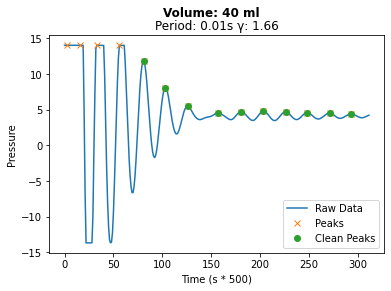

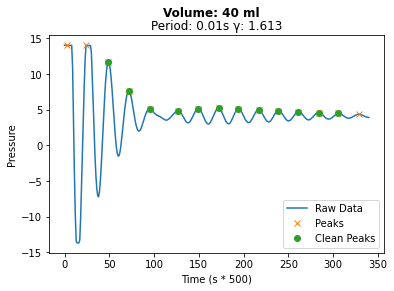

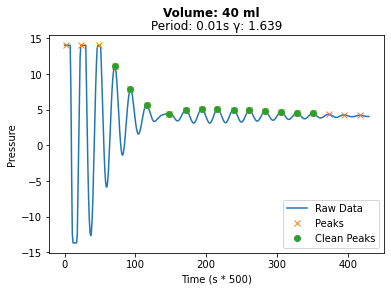

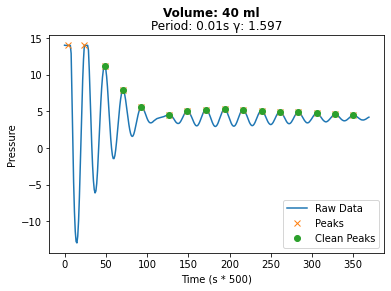

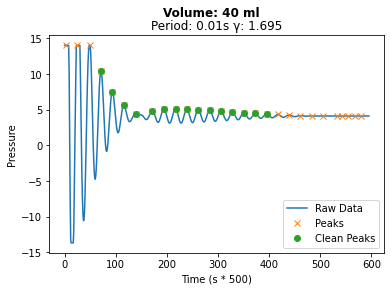

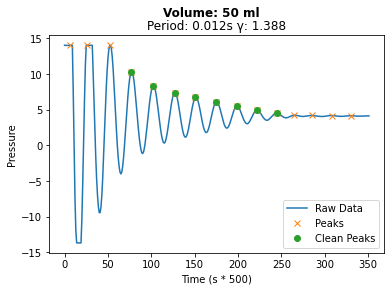

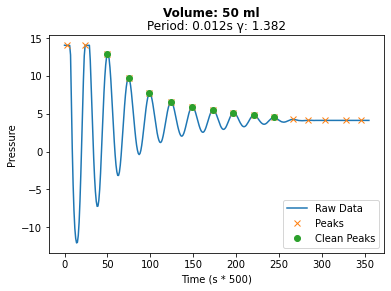

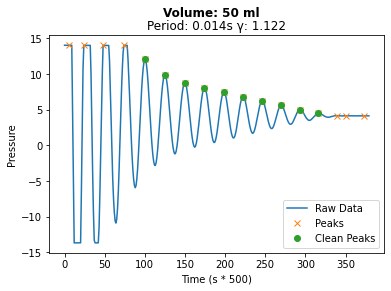

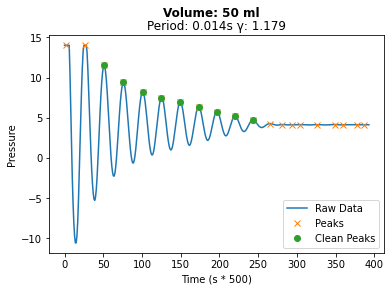

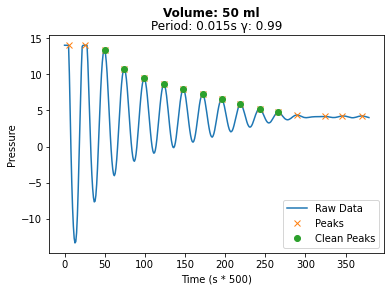

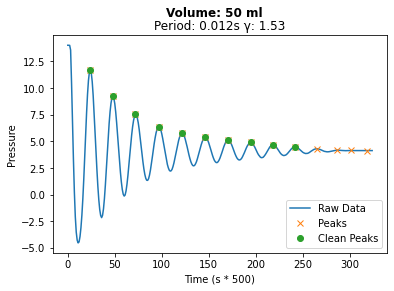

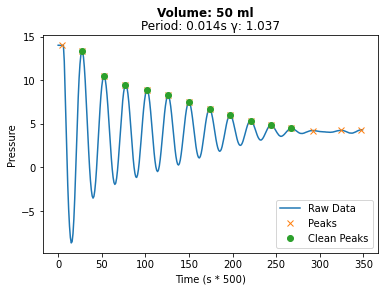

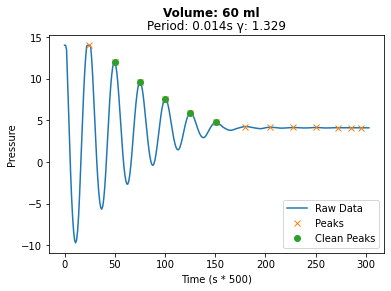

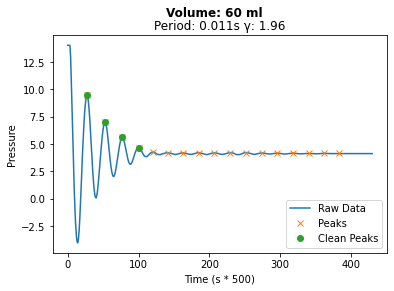

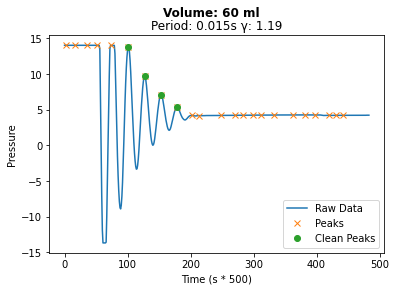

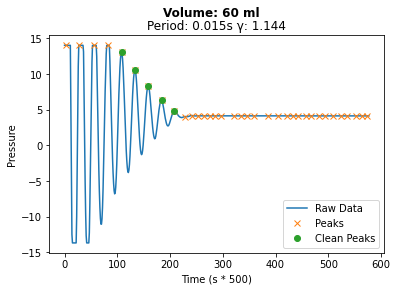

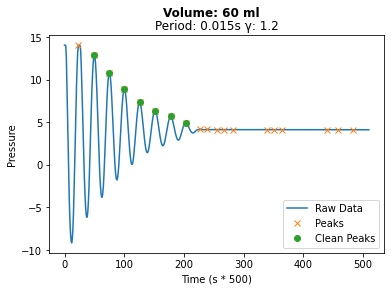

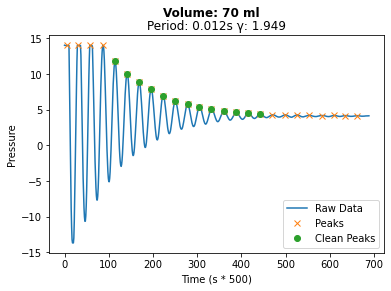

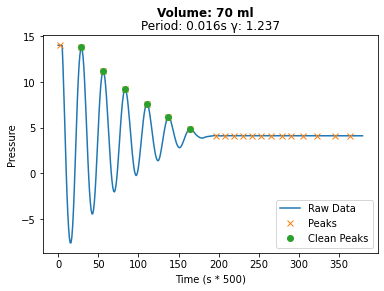

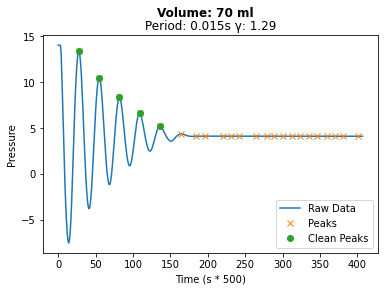

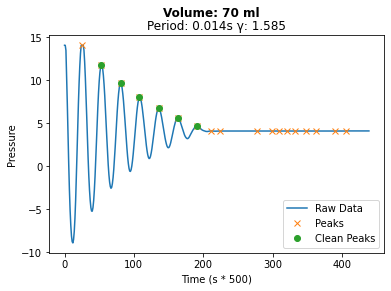

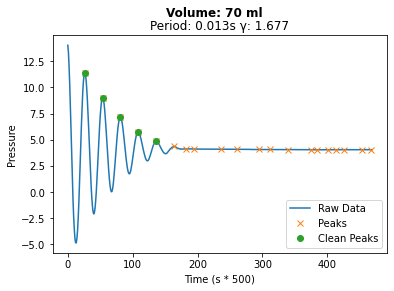

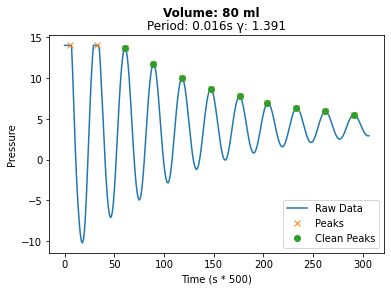

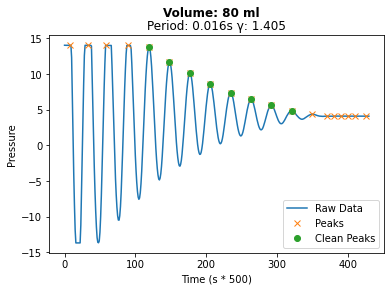

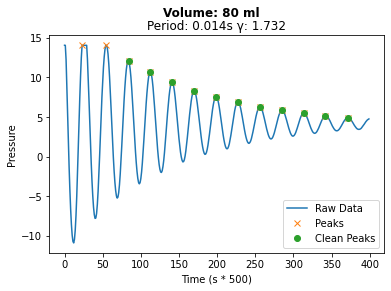

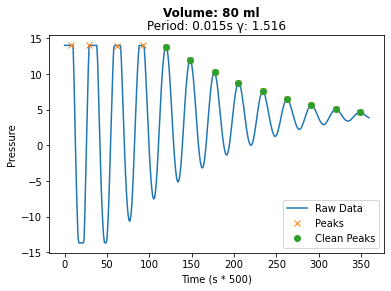

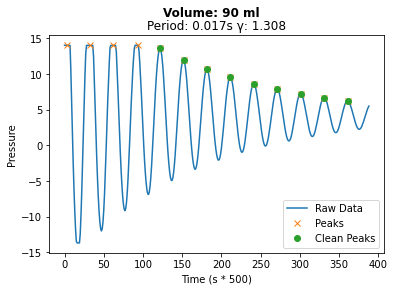

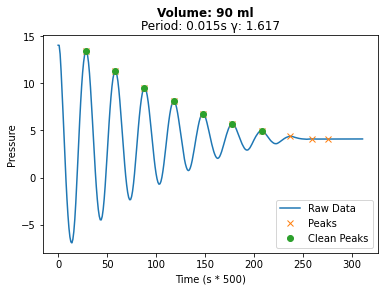

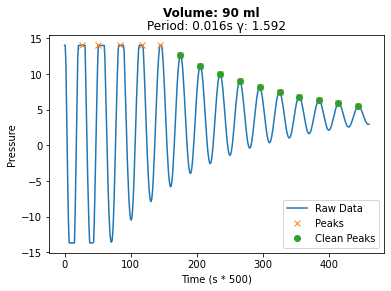

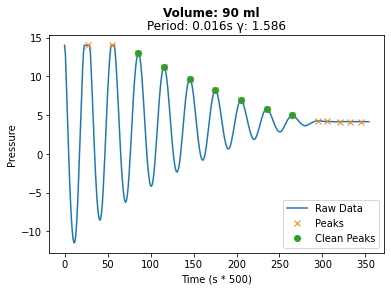

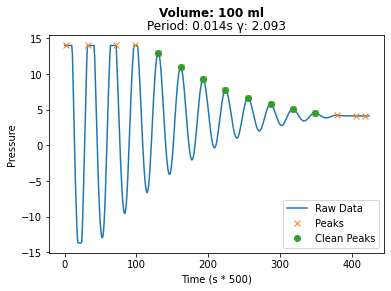

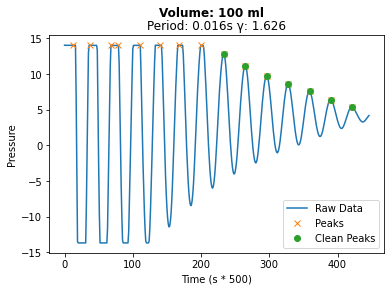

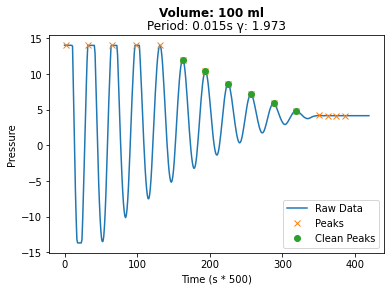

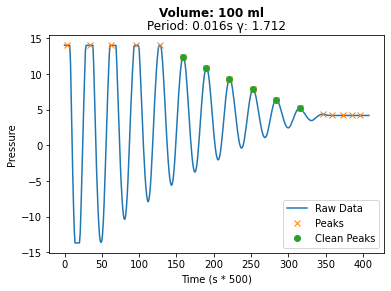

γ= 1.498 ± 0.051


In [5]:
for x in range(4,11):
    volume=x*10
    #Get data from text file, arguments are just based on formatting of .txt
    df = pd.read_csv('H4/Syringe/'+str(x*10)+'ml.txt', delim_whitespace=True, skiprows=6, error_bad_lines=False )

    #Put this data into a list as strings, getting rid of the formatting stuff that isn't numbers
    t_list_str = list(df.iloc[:,2].astype(str).str.slice(start=0,stop=6,step=1))

    #Change list entries of t to floats from strings 
    t_list=[float(u) for u in t_list_str]

    #Initalise array here so they clear every iteration
    orig = np.zeros((2,len(t_list)))
    split_up={}

    #Create 2-D array with orginal values
    orig[0,:]=t_list
    orig[1,:]=range(len(t_list))
    
    
    #Find Peaks with scipy, min dist between peaks is 45 points
    peaks, _ = find_peaks(orig[0,:], distance=300) 
    
    #Clean data to only get top peaks
    clean_peaks = np.zeros((2,len(t_list)))
    clean_peaks[1,:] = range(len(t_list))  #x-values
    clean_peaks[clean_peaks==0] = np.nan
    for n in peaks:
        if orig[0,n]>10:
            clean_peaks[0,n]=orig[0,n]
    
    #Find the average time periods
    peak_pos=[]
    for n in range(len(t_list)):
        if clean_peaks[0,n]>0:
            peak_pos.append(clean_peaks[1,n])
            
    #Turn them into ints
    peak_pos=[int(i) for i in peak_pos]
    
    #Add an entry at zero so we can grab the first chunk of data before the oscillations start
    peak_pos.insert(0,0)

    
    
    #Split up each flick into seperate arrays stored in a dict with key value of the position of the first peak
    
    for i in range(1,len(peak_pos)-1):
        
        #copy only the raw data that is between the biggest peaks (each array is now 1 flick)
        split_up[peak_pos[i]]=t_list[peak_pos[i]:peak_pos[i+1]]
        
        #Remove second half of list as the oscillations all take place at start
        split_up[peak_pos[i]]=split_up[peak_pos[i]][:len(split_up[peak_pos[i]])-(int(2*len(split_up[peak_pos[i]])/3))]
        
        #Turn this into an array to do peak finding on 
        oscillations=np.zeros((2,len(split_up[peak_pos[i]])))
        oscillations[0,:]=range(len(split_up[peak_pos[i]]))
        oscillations[1,:]=split_up[peak_pos[i]]
        
        #Run peak-finding on these arrays
        time_peaks, _ = find_peaks(oscillations[1,:], distance=10)
       
        
        #Clean peaks to get rid of intial clipping and flat part of tail
        clean_time_peaks = np.zeros((2,len(split_up[peak_pos[i]])))
        clean_time_peaks[0,:] = range(len(split_up[peak_pos[i]]))  #x-values
        
        
        for n in time_peaks:
            if split_up[peak_pos[i]][n]<14 and split_up[peak_pos[i]][n]>4.4 :
                clean_time_peaks[1,n]=split_up[peak_pos[i]][n]
       
    
        #Find time-periods inbetween peaks
        peak_pos_diff=np.diff(clean_time_peaks[1,:]) 
        peak_pos_diff=[i for i in peak_pos_diff if i>0]
        time_periods=[0.002*i for i in peak_pos_diff]
        
        
        #Remove first time period as still sometimes clipping 
        del time_periods[:1]
        
        
        #Gamma Values
        EoT=stats.sem(time_periods)
        found_gamma, err_found_gamma = gammaWithError(m,volume,A,P,np.mean(time_periods),EoM,EoV,EoA,EoP,EoT)
        avg_tot_gamma.append(found_gamma)
        error_found_gammas.append(err_found_gamma)
       
        
        #For nicer plots (don't show zero values)
        clean_time_peaks[clean_time_peaks==0] = np.nan
        
        
        #Generate Plots 
        fig = plt.figure()
        ax0 = fig.add_subplot(111)
        fig.suptitle("Volume: "+ str(volume)+" ml", fontsize=12, fontweight='bold')
        ax0.set_title("Period: "+str(round(np.mean(time_periods),3))+"s "+"γ: "+str(round(found_gamma,3)))
        ax0.plot(oscillations[0,:],oscillations[1,:], label="Raw Data")
        ax0.plot(time_peaks,oscillations[1,time_peaks], "x", label="Peaks")
        ax0.plot(clean_time_peaks[0,:],clean_time_peaks[1,:], "o", label="Clean Peaks")
        plt.legend(loc='lower right')
        plt.xlabel("Time (s * 500)") 
        plt.ylabel("Pressure")
        plt.show()
    

#Combine errors using partial derivatives    
error_found_gammas=[(i*(1/(len(error_found_gammas))))**2 for i in error_found_gammas]

#Print final result
print("γ= "+str(round(np.mean(avg_tot_gamma),3))+" "+ u"\u00B1" +" "+str(round((np.sum(error_found_gammas))**(0.5),3)))


If you get any errors here, re-run all cells in descending order :)